Insider trading activities, especially those involving executives and significant shareholders, often carry implicationsfor market trends and investor sentiment. This study on predicting market reactions to insider trading across multiple companies, integrating diverse data sources to enhance forecasting accuracy. We utilized SEC EDGAR Form 4 filings for insider transactions, historical stock data from Yahoo Finance, and macroeconomic indicators from Federal Reserve Economic Data (FRED) to construct a comprehensive predictive model. Our methodology combines regression and classification techniques to predict both the direction and magnitude of market changes following insider trades. The results demonstrate that insider transactions, when analyzed alongside market and economic factors, can effectively forecast short-term market reactions with significant accuracy. These findings contribute to the field of financial market prediction, offering a data-driven approach for investors and analysts to anticipate market behavior in response to insider trading events.
The following analysis is done on CVS HEALTH.

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy.stats import sem, ttest_1samp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
# Replace with the paths to your files if necessary
insider_trades = pd.read_excel('C:/Users/Admin/Desktop/DS Project/insider data/cvs_health.xlsx')
stock_prices = pd.read_excel('C:/Users/Admin/Desktop/DS Project/insider data/historical_prices_cvs.xlsx')

In [21]:
print("Insider Trades Columns:", insider_trades.columns)
print("Stock Prices Columns:", stock_prices.columns)

Insider Trades Columns: Index(['X', 'Filing_Date', 'Trade Date', 'Ticker', 'Insider Name', 'Title',
       'Trade_Type  ', 'Price', 'Qty', 'Owned', 'ΔOwn', 'Value', '1d', '1w',
       '1m', '6m'],
      dtype='object')
Stock Prices Columns: Index(['Date', ' Open', ' High', ' Low', ' Close', ' Volume'], dtype='object')


In [45]:
# Convert 'Trade Date' and 'Date' columns to datetime format
insider_trades.iloc[:, 2]= pd.to_datetime(insider_trades.iloc[:, 2])
stock_prices.iloc[:, 0] = pd.to_datetime(stock_prices.iloc[:, 0])

# Sort data by date
insider_trades.sort_values(by=insider_trades.columns[2], inplace=True)
stock_prices.sort_values(by=stock_prices.columns[0], inplace=True)

# Rename columns in stock_prices for easier access (remove spaces)
stock_prices.columns = [col.strip() for col in stock_prices.columns]

In [61]:
# Step 1: Calculate Daily Returns for Stock Prices
stock_prices['return'] = stock_prices['Close'].pct_change()

# Step 2: Filter for 'Buy' Insider Trading Events
# Assuming 'Trade_Type  ' column specifies 'Buy' for purchase transactions
buy_trades = insider_trades[insider_trades.iloc[:, 6].str.strip() == 'P - Purchase']

buy_trades

,X,Filing_Date,Trade Date,Ticker,Insider Name,Title,Trade_Type,Price,Qty,Owned,ΔOwn,Value,1d,1w,1m,6m
248,NaN,2006-03-16 16:27:11,2006-03-14,CVS,Bodine Chris W,EVP,P - Purchase,$30.57,26,187015,0.00,+$795,0.0,0.0,4.0,18.0
247,NaN,2006-11-28 16:07:05,2006-11-27,CVS,Swift Richard J,Dir,P - Purchase,$27.38,3000,4000,3.00,"+$82,140",3.0,6.0,13.0,41.0
239,NaN,2007-05-24 15:15:44,2007-05-23,CVS,Headrick Roger L,Dir,P - Purchase,$38.01,6495,326462,0.02,"+$246,896",1.0,1.0,-4.0,9.0
219,D,2008-03-07 15:37:27,2008-03-05,CVS,Denton David M,Controller,P - Purchase,$40.23,1242,28305,0.05,"+$49,966",-1.0,2.0,5.0,-7.0
215,D,2008-11-18 15:53:11,2008-11-17,CVS,Brennan Troyen A,Chief Medical Officer,P - Purchase,$28.26,10616,30964,0.52,"+$300,008",2.0,0.0,-6.0,6.0
214,D,2008-12-31 12:07:42,2008-12-29,CVS,McGuigan Stuart M,"SVP, CIO",P - Purchase,$27.30,9182,18364,1.00,"+$250,669",1.0,4.0,-5.0,13.0
201,M,2009-11-13 14:30:50,2009-11-11,CVS,Ryan Thomas M,"CEO, Pres",P - Purchase,$29.96,17000,3064031,0.01,"+$509,342",2.0,5.0,9.0,21.0
200,NaN,2009-11-13 14:33:28,2009-11-12,CVS,Williams Kristen Gibney,Dir,P - Purchase,$30.00,1000,63408,0.02,"+$29,998",2.0,5.0,9.0,21.0
198,D,2010-01-06 16:27:55,2010-01-04,CVS,Lofberg Per Gh,"Pres, Caremark Pharm Serv",P - Purchase,$32.98,45483,90966,1.00,"+$1,500,029",4.0,3.0,-4.0,-10.0
196,NaN,2010-02-19 15:45:42,2010-02-17,CVS,Lofberg Per Gh,"Pres, Caremark Pharm Serv",P - Purchase,$34.10,147000,238204,1.61,"+$5,012,582",1.0,0.0,1.0,-14.0


In [73]:
# Step 3: Event Study Analysis - Calculate Cumulative Abnormal Return (CAR)
event_window = 5  # Event window size (e.g., 5 days before and after the event)

# Initialize an empty list to store CAR for each event
car_results = []

for _, trade in buy_trades.iterrows():
    event_date = trade.iloc[2]  # Access the third column,'Trade Date'
    
    # Define window around the event
    start_date = event_date - timedelta(days=event_window)
    end_date = event_date + timedelta(days=event_window)
    
    # Get stock data within the event window and create a copy
    window_data = stock_prices[(stock_prices['Date'] >= start_date) & (stock_prices['Date'] <= end_date)].copy()
    
    # Calculate abnormal returns by subtracting the average market return (baseline)
    baseline_return = stock_prices['return'].mean()
    window_data['abnormal_return'] = window_data['return'] - baseline_return
    
    # Calculate cumulative abnormal return (CAR) for the event
    car = window_data['abnormal_return'].sum()
    car_results.append({'event_date': event_date, 'CAR': car})

# Convert CAR results into a DataFrame
car_df = pd.DataFrame(car_results)
print(car_df)


   event_date       CAR
0  2006-03-14 -0.143934
1  2006-11-27 -0.052649
2  2007-05-23  0.012819
3  2008-03-05 -0.236418
4  2008-11-17 -0.103175
5  2008-12-29  0.069913
6  2009-11-11 -0.056954
7  2009-11-12  0.022799
8  2010-01-04 -0.155878
9  2010-02-17  0.102275
10 2010-04-26 -0.138531
11 2010-08-09 -0.180481
12 2010-08-17 -0.113053
13 2011-02-08  0.096402
14 2012-02-13 -0.086298
15 2012-07-09  0.057148
16 2012-10-01 -0.040168
17 2018-05-04  0.073466
18 2018-05-04  0.073466
19 2019-03-01 -0.134024
20 2019-03-01 -0.134024
21 2019-03-08 -0.074363
22 2019-03-08 -0.074363
23 2019-03-11  0.025829
24 2019-03-11  0.025829
25 2020-05-11  0.028291
26 2021-02-17 -0.243125
27 2021-08-05  0.027614
28 2022-02-10 -0.026748
29 2023-05-03 -0.023692
30 2023-11-03  0.162597
31 2024-05-02 -0.142816
32 2024-05-02 -0.142816


We are focusing on the following types of visualizations to capture market reactions to insider trading events, especially regarding the direction and magnitude of changes in CVS Health’s stock price. 

**Cumulative Abnormal Return (CAR) Around Insider Trading Events:**

-> The cumulative abnormal return (CAR) is a major indicator used by investors and financial analysts to assess a company or portfolio's actual performance in comparison to expectations. CAR calculates an investment's total anomalous returns over a set period of time, typically following an event such as a merger, earnings announcement, or regulatory change. If you're reviewing an investment and want to know how an event affected its returns, understanding CAR can help.
-> This following visualization shows the CAR for each event to see the magnitude and direction of stock price movement around insider trades.

**Plotting CAR for Each Insider Trading Event:**
Purpose: This line plot displays the CAR for each insider trading event individually, showing the direction and magnitude of stock price movement (abnormal return) for each event.

Each point represents a cumulative abnormal return for a specific insider trade. The x-axis shows the event date, and the y-axis shows CAR. A line at 0 on the y-axis represents no abnormal return.

Positive CAR values indicate that the stock price increased more than the baseline average return after the insider purchase, suggesting market optimism.

Negative CAR values show a decline beyond the baseline, possibly reflecting market skepticism.

Insights: By looking at each event, you can identify patterns, such as whether insider trading events frequently lead to positive or negative abnormal returns.

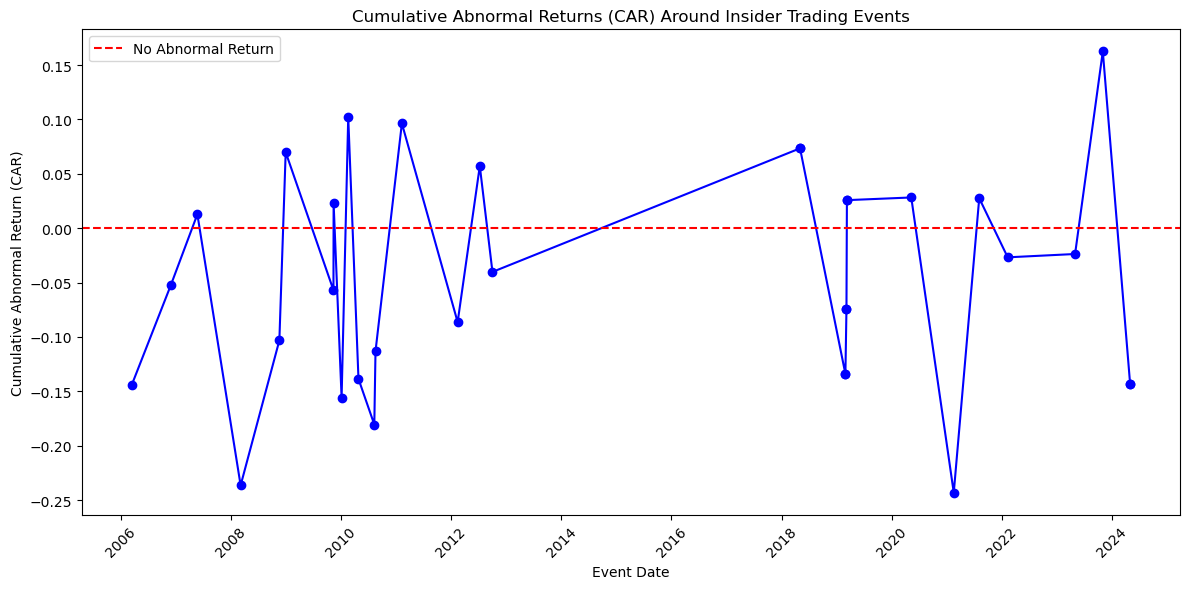

In [75]:
# 1. Plotting CAR for Each Insider Trading Event
plt.figure(figsize=(12, 6))
plt.plot(car_df['event_date'], car_df['CAR'], marker='o', linestyle='-', color='blue')
plt.axhline(0, color='red', linestyle='--', label="No Abnormal Return")
plt.title("Cumulative Abnormal Returns (CAR) Around Insider Trading Events")
plt.xlabel("Event Date")
plt.ylabel("Cumulative Abnormal Return (CAR)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Average CAR Across All Insider Events with Confidence Intervals:**

Purpose: This bar plot shows the average CAR across all insider trading events, with a 95% confidence interval (CI) around the mean.

The bar represents the mean CAR across all insider events, and the error bars indicate the 95% CI. If the CI does not intersect the 0 line, it suggests a statistically significant average effect.

If the bar (mean CAR) is positive and does not intersect with 0, it implies a general tendency for the stock price to increase following insider trades.

If it’s negative and does not intersect with 0, it suggests a tendency for the stock price to decrease post-insider trading events.

Insights: This visualization summarizes the overall impact of insider trades on stock prices, indicating whether they lead to consistent upward or downward movements and if this impact is statistically significant.

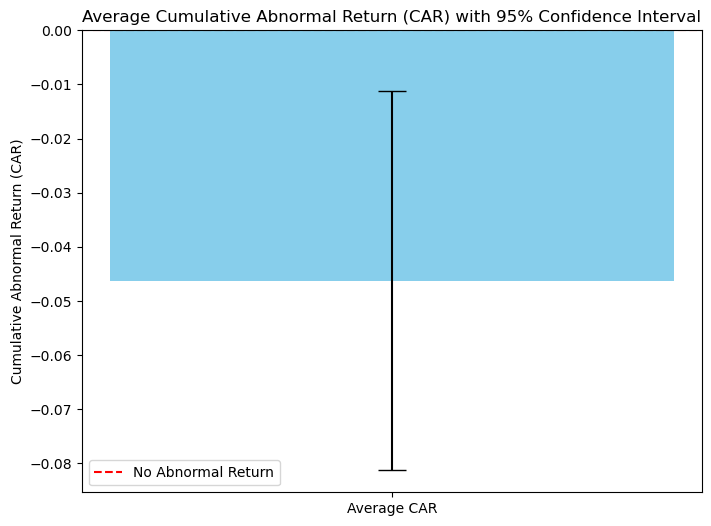

In [77]:
# 2. Average CAR Across All Insider Events with Confidence Intervals
mean_car = car_df['CAR'].mean()
car_sem = sem(car_df['CAR'])

plt.figure(figsize=(8, 6))
plt.bar(['Average CAR'], [mean_car], yerr=[1.96 * car_sem], capsize=10, color='skyblue')
plt.axhline(0, color='red', linestyle='--', label="No Abnormal Return")
plt.title("Average Cumulative Abnormal Return (CAR) with 95% Confidence Interval")
plt.ylabel("Cumulative Abnormal Return (CAR)")
plt.legend()
plt.show()

**Histogram of CAR Values Across Events:**

Purpose: This histogram visualizes the distribution of CAR values across all insider trading events, helping to identify the overall direction (positive or negative) and spread of market reactions.

A right-skewed distribution with more positive CAR values suggests that insider trades tend to generate positive abnormal returns, indicating favorable market sentiment.

A left-skewed distribution with more negative CAR values would imply that insider trades often coincide with negative abnormal returns.

If CAR values are centered around zero, this suggests minimal consistent market reaction to insider trades.

Insights: This histogram provides a quick visual summary of how insider trades affect stock prices on average. If the distribution is largely positive, it would align with the hypothesis that insider purchases are a bullish signal to the market.

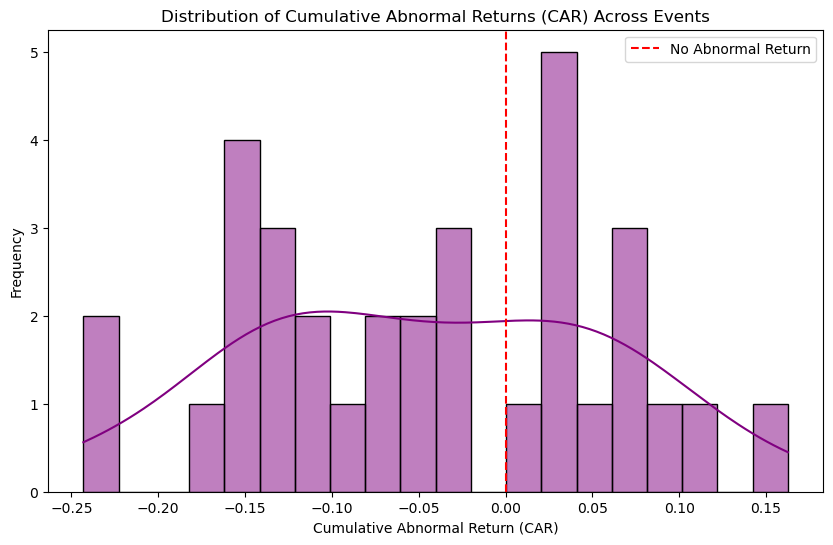

In [79]:
# 3. Histogram of CAR Values Across Events
plt.figure(figsize=(10, 6))
sns.histplot(car_df['CAR'], bins=20, color='purple', kde=True)
plt.axvline(0, color='red', linestyle='--', label="No Abnormal Return")
plt.title("Distribution of Cumulative Abnormal Returns (CAR) Across Events")
plt.xlabel("Cumulative Abnormal Return (CAR)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

**Statistical Test for CAR Significance:**

Purpose: This statistical test (t-test) checks if the average CAR is significantly different from zero across all events, providing a quantitative measure of significance.

A p-value less than 0.05 would indicate that the CARs are significantly different from zero, supporting the notion that insider trades have a significant impact on stock prices.

If the p-value is greater than 0.05, we do not have enough statistical evidence to conclude that insider trades consistently impact stock price movements.

Insights: This test provides quantitative validation for your findings. A significant result implies that the impact of insider trades is non-random and could be used for predicting market behavior in response to insider events.

In [81]:
# Step 4: Statistical Test for CAR Significance
# Run a t-test to check if CARs are significantly different from zero
t_stat, p_value = ttest_1samp(car_df['CAR'], 0)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation of p-value:
# - If p-value < 0.05, CARs are significantly different from zero at a 5% level.

T-statistic: -2.58474166359063, P-value: 0.014510444380273838


**These visualizations, together, help identify both individual and aggregate trends, allowing you to determine the direction, consistency, and significance of market reactions to insider trading events.**

**Predictive Modeling of Post-Trade Price Movements:**

Description: Build a predictive model that uses insider trading details (e.g., role, trade size, timing) and other stock/macro data (e.g., historical prices, trading volumes) to forecast short-term price movements.

Insight: This helps assess the predictive power of insider trading events on CVS Health's stock, aligning with your abstract’s aim of enhancing forecasting accuracy.

Steps:
Use insider trading details, historical stock returns, trading volume, and relevant macroeconomic indicators as features.
Build a model (e.g., logistic regression, random forest) to predict the direction of stock movement (up/down) or the CAR magnitude after each trade.
Potential Visualization: Feature importance plot for model insights, or ROC curve for classification performance.

In [87]:
data = pd.merge(insider_trades, stock_prices, left_on= insider_trades.iloc[:, 2], right_on=stock_prices.iloc[:, 0])
data.fillna(0, inplace=True)
data.columns

Index(['key_0', 'X', 'Filing_Date', 'Trade Date', 'Ticker', 'Insider Name',
       'Title', 'Trade_Type  ', 'Price', 'Qty', 'Owned', 'ΔOwn', 'Value', '1d',
       '1w', '1m', '6m', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'return'],
      dtype='object')

In [97]:
# Calculate daily, weekly, and monthly percentage changes in price and volume
data['Daily_Price_Change'] = data['Close'].pct_change(periods=1)
data['Weekly_Price_Change'] = data['Close'].pct_change(periods=5)
data['Monthly_Price_Change'] = data['Close'].pct_change(periods=21)

data['Daily_Volume_Change'] = data['Volume'].pct_change(periods=1)
data['Weekly_Volume_Change'] = data['Volume'].pct_change(periods=5)
data['Monthly_Volume_Change'] = data['Volume'].pct_change(periods=21)

# Calculate moving averages for trend indication
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()

# Volatility as a rolling standard deviation
data['Volatility'] = data['Close'].rolling(window=5).std()


In finance, volatility is an indicator of the degree of variation in a stock's price over a specific period and is often used to assess risk. A higher standard deviation means more price fluctuation, indicating higher volatility, while a lower standard deviation suggests more stable prices.

In [99]:
# Define target variable based on post-trade price change (up: 1, down: 0)
data['Price_Direction'] = (data['Daily_Price_Change'].shift(-1) > 0).astype(int)
data = data.dropna(subset=['Price_Direction'])


In [105]:
# Define feature columns
features = [
    'Daily_Price_Change', 'Weekly_Price_Change', 'Monthly_Price_Change',
    'Daily_Volume_Change', 'Weekly_Volume_Change', 'Monthly_Volume_Change',
    'MA_5', 'MA_20', 'MA_50', 'Volatility'
]

X = data[features]
y = data['Price_Direction']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [107]:
# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]


In [111]:
# Classification report
print(classification_report(y_test, y_pred))

# AUC-ROC Score
roc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {roc_score:.2f}")


              precision    recall  f1-score   support

           0       0.45      0.53      0.49        36
           1       0.39      0.32      0.35        34

    accuracy                           0.43        70
   macro avg       0.42      0.43      0.42        70
weighted avg       0.42      0.43      0.42        70

AUC-ROC Score: 0.48


**Feature Importance Plot: This plot sorts features by their importance, providing clarity on which features contribute the most to the model’s predictions. The use of color gradients and annotations enhances readability.**

C:\Users\Admin\AppData\Local\Temp\ipykernel_19744\1451773346.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")


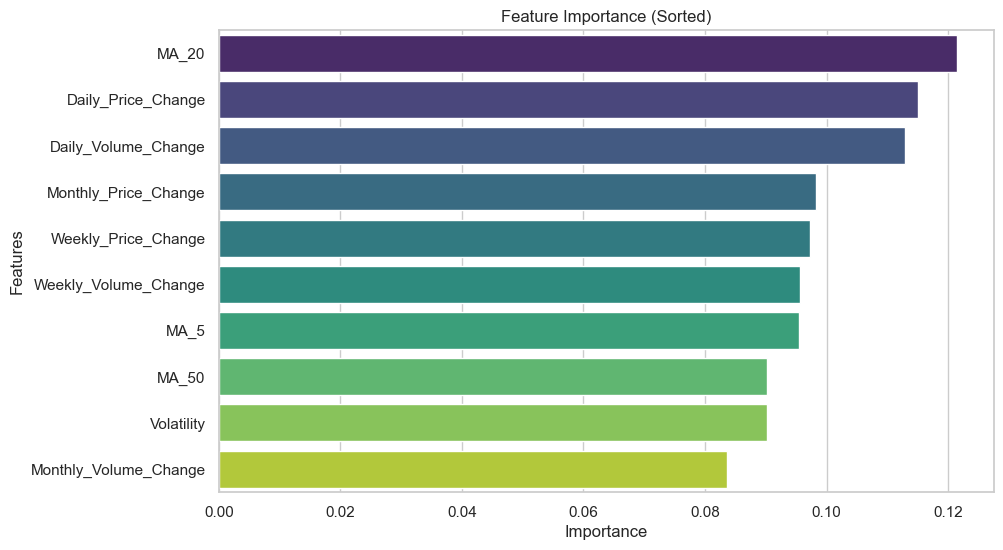

In [113]:

# Set style for better visuals
sns.set(style="whitegrid")

# Step 1: Enhanced Feature Importance Plot
def plot_feature_importance(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    sorted_features = [features[i] for i in indices]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=sorted_features, palette="viridis")
    plt.title("Feature Importance (Sorted)")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

plot_feature_importance(model, features)

**ROC Curve: A refined ROC curve with an AUC value clearly indicated, and a diagonal line for reference, gives insight into model performance across different thresholds.**

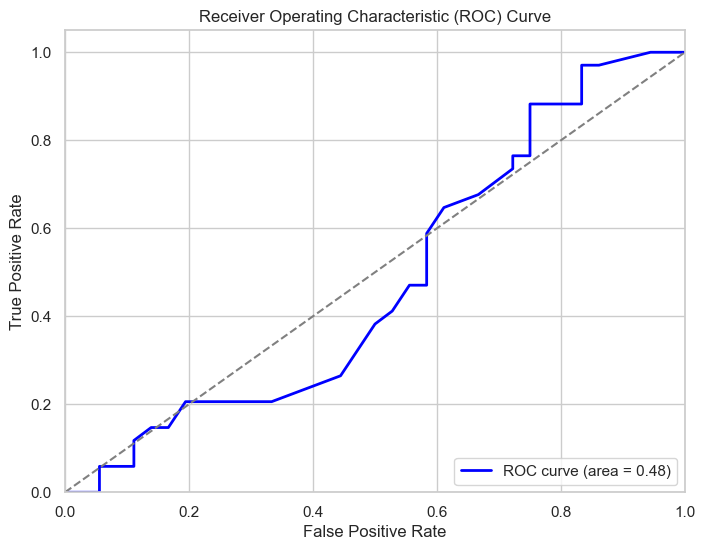

In [117]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
#Detailed ROC Curve Plot
def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_curve(y_test, y_pred_proba)

**Confusion Matrix: This heatmap provides a visual breakdown of true positive, true negative, false positive, and false negative predictions, offering immediate insight into model accuracy.**

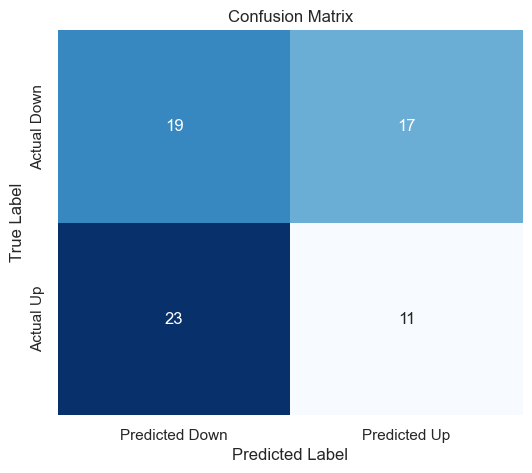

In [119]:
# Confusion Matrix with Heatmap
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Down', 'Predicted Up'], 
                yticklabels=['Actual Down', 'Actual Up'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred)


**Correlation Heatmap: This plot helps identify correlations between features, which can reveal redundancy in predictors and guide feature selection.**

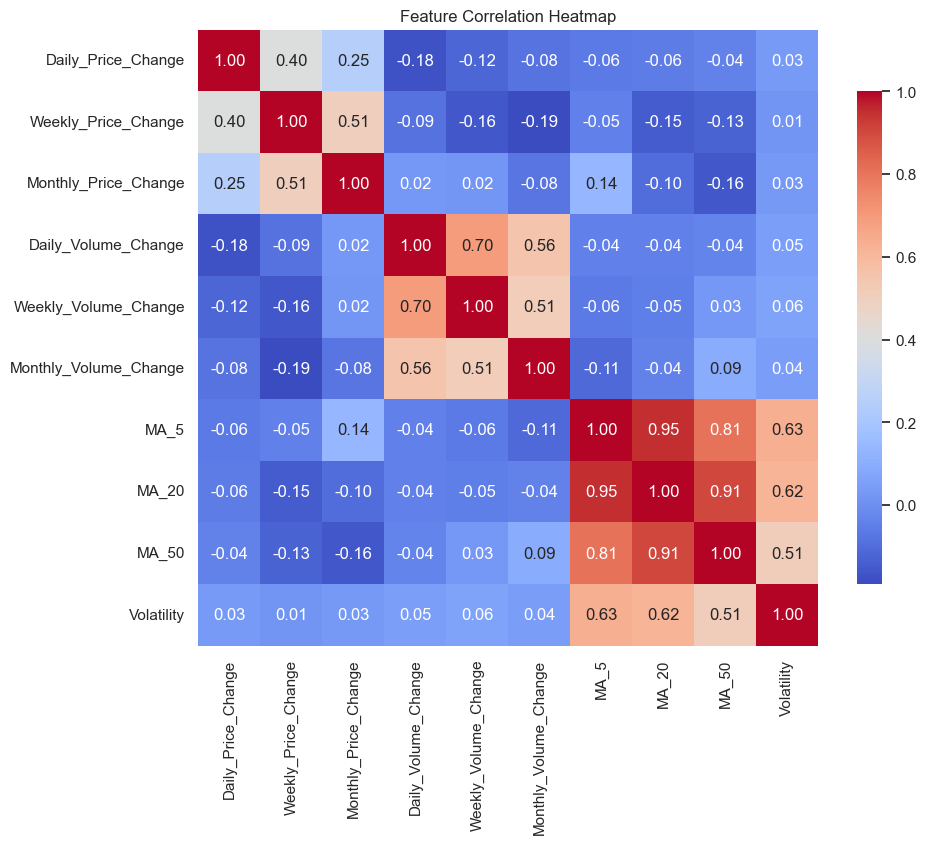

In [121]:
# Correlation Heatmap for Features
plt.figure(figsize=(10, 8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'shrink': .8})
plt.title("Feature Correlation Heatmap")
plt.show()

In [125]:
# Example data
data = pd.DataFrame({
    'Date': pd.date_range(start='2023-01-01', periods=10, freq='D'),
    'Close': [100, 102, 101, 104, 107, 105, 108, 110, 111, 115]
})

# Set the Date as the index
data.set_index('Date', inplace=True)

# Calculate daily returns
data['Daily_Return'] = data['Close'].pct_change(periods=1)

# Calculate weekly returns (assuming daily data, 5 trading days in a week)
data['Weekly_Return'] = data['Close'].pct_change(periods=5)

# Calculate monthly returns (approx. 21 trading days in a month)
data['Monthly_Return'] = data['Close'].pct_change(periods=21)

print(data)

            Close  Daily_Return  Weekly_Return  Monthly_Return
Date                                                          
2023-01-01    100           NaN            NaN             NaN
2023-01-02    102      0.020000            NaN             NaN
2023-01-03    101     -0.009804            NaN             NaN
2023-01-04    104      0.029703            NaN             NaN
2023-01-05    107      0.028846            NaN             NaN
2023-01-06    105     -0.018692       0.050000             NaN
2023-01-07    108      0.028571       0.058824             NaN
2023-01-08    110      0.018519       0.089109             NaN
2023-01-09    111      0.009091       0.067308             NaN
2023-01-10    115      0.036036       0.074766             NaN
